In [1]:
import pandas as pd
import pyarrow as pa 
import pyarrow.parquet as pq 
import os
import time
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

In [2]:
data_dir = "Optiver_additional_data/Optiver_additional_data/"
feat = pd.read_parquet(data_dir + "order_book_feature.parquet")   # seconds 0–1799
tgt  = pd.read_parquet(data_dir + "order_book_target.parquet")    # seconds 1800–3599

full = pd.concat([feat, tgt], axis=0, ignore_index=True)

full_sorted = full.sort_values(
    by=["stock_id", "time_id", "seconds_in_bucket"],
    ascending=[True,     True,      True]
).reset_index(drop=True)

full_sorted = full_sorted[full_sorted["time_id"] >= 12].reset_index(drop=True)
full_sorted.tail()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
35363978,104919,1199,3595.0,362.73,362.74,362.72,362.75,200,1190,1200,1600
35363979,104919,1199,3596.0,362.68,362.70,362.67,362.71,800,200,1600,1400
35363980,104919,1199,3597.0,362.69,362.70,362.68,362.71,200,900,1400,1400
35363981,104919,1199,3598.0,362.72,362.73,362.71,362.74,200,1000,900,500
35363982,104919,1199,3599.0,362.80,362.81,362.79,362.82,200,300,600,300


In [3]:
pri_dir = "PRI/"
clustered30 = pd.read_parquet(pri_dir + "centroidData.parquet")

clustered30.tail()

,cluster,bucket_start,day_of_week,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling
1435,2,3540,4,1.785525e-07,0.000057,0.000005,0.000877,0.000311,0.744764,0.023388,7695.066667,5.877696,0.000043,-8.275322e-07
1436,2,3570,1,-9.809133e-07,0.000062,-0.000029,0.000979,0.000340,0.778634,0.030835,8804.430667,6.581689,0.000050,-1.226523e-06
1437,2,3570,2,1.475075e-07,0.000059,0.000004,0.000927,0.000322,0.766076,0.019936,9048.245333,7.615554,0.000050,-8.711303e-07
1438,2,3570,3,-2.545892e-07,0.000057,-0.000008,0.000891,0.000312,0.747462,0.001503,9778.421333,7.982283,0.000049,1.941037e-06
1439,2,3570,4,-3.793987e-07,0.000058,-0.000011,0.000914,0.000319,0.765260,-0.002525,8666.566667,5.461907,0.000049,3.367067e-07


In [4]:
pri_dir = "PRI/"
train_df = pd.read_parquet(pri_dir + "train_60s_clustered.parquet")

train_df.head()

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,...,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week,cluster
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,...,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,...,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,...,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,...,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,...,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1,1


In [5]:
test_df = pd.read_parquet(pri_dir + "test_60s.parquet")
test_df.head()

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,36.0,0,-0.000039,0.000398,-0.002262,0.017007,0.003016,0.379224,-0.463014,31676.0,1.100557,0.000190,-0.000008,2021-01-11,11:00:00,5,5,Friday,1
1,8382.0,36.0,60,-0.000015,0.000282,-0.000921,0.012010,0.002167,0.358667,0.109190,34189.0,25.326880,0.000351,-0.000142,2021-01-11,11:00:00,5,5,Friday,1
2,8382.0,36.0,120,0.000015,0.000397,0.000897,0.017325,0.003051,0.380167,-0.218332,19842.0,2.575445,0.000336,0.000078,2021-01-11,11:00:00,5,5,Friday,1
3,8382.0,36.0,180,-0.000001,0.000256,-0.000066,0.009691,0.001969,0.364000,-0.160622,17657.0,2.497647,0.000201,0.000003,2021-01-11,11:00:00,5,5,Friday,1
4,8382.0,36.0,240,0.000031,0.000457,0.001875,0.019706,0.003522,0.413750,-0.165097,30711.0,3.475366,0.000710,-0.000157,2021-01-11,11:00:00,5,5,Friday,1


In [6]:
pri_dir = "PRI/"
test_df = pd.read_parquet(pri_dir + "test1_30s.parquet")

test_df.head()

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,36.0,0,0.000006,0.000320,0.000161,0.006721,0.001664,0.419821,-0.480306,20931.0,1.343431,0.000060,-0.000045,2021-01-11,11:00:00,5,5,Friday,1
1,8382.0,36.0,30,-0.000081,0.000460,-0.002423,0.010286,0.002516,0.341333,-0.446875,10745.0,0.873875,0.000190,-0.000008,2021-01-11,11:00:00,5,5,Friday,1
2,8382.0,36.0,60,-0.000055,0.000217,-0.001638,0.005107,0.001207,0.352333,0.055332,16975.0,35.388324,0.000152,-0.000035,2021-01-11,11:00:00,5,5,Friday,1
3,8382.0,36.0,90,0.000024,0.000333,0.000718,0.006903,0.001800,0.365000,0.163048,17214.0,15.265435,0.000351,-0.000142,2021-01-11,11:00:00,5,5,Friday,1
4,8382.0,36.0,120,0.000074,0.000438,0.002216,0.009609,0.002391,0.385000,-0.249060,13808.0,2.707671,0.000274,-0.000249,2021-01-11,11:00:00,5,5,Friday,1


## EDA

In [7]:
def describe_volatility_and_log_returns(df, time_id=5):
    df_filtered = df[df["time_id"] == time_id]

    volatility_stats_list =  []

    if "volatility" in df_filtered.columns:
        if len(df_filtered) > 0:
            volatility_stats_list.append({
                "mean": df_filtered.mean(),
                "std": df_filtered.std(),
                "min": df_filtered.min(),
                "max": df_filtered.max(),
                "skewness": skew(df_filtered),
                "kurtosis": kurtosis(df_filtered)
                })

    volatility_df = pd.DataFrame(volatility_stats_list)

    return volatility_df

descriptive_df = describe_volatility_and_log_returns(train_df)

descriptive_df.head()

""


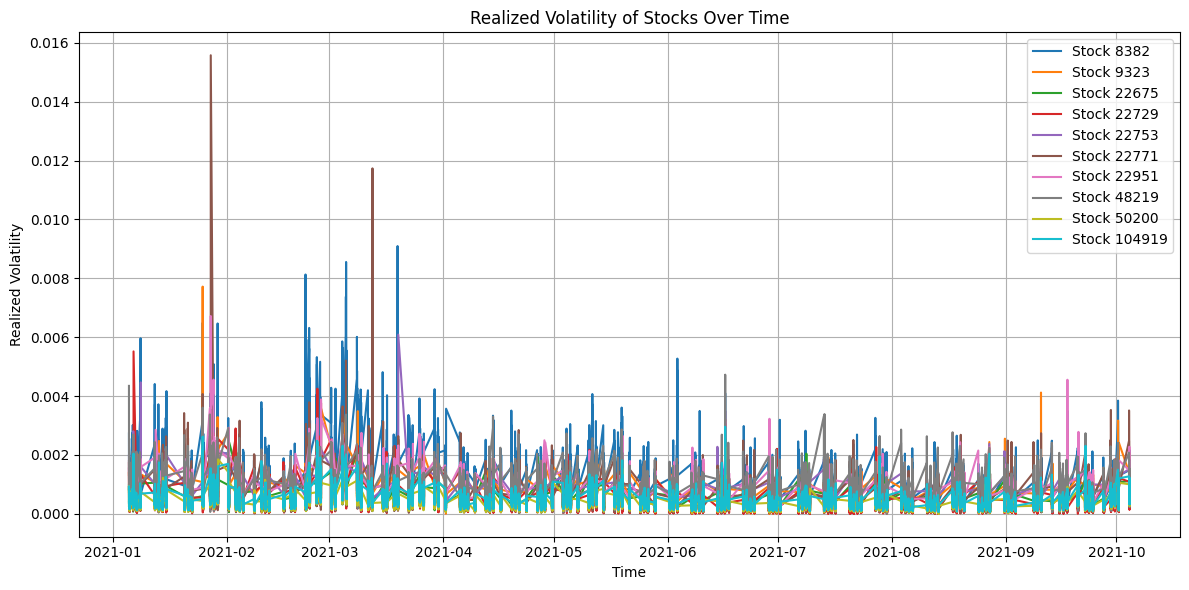

In [8]:
train_df['timestamp'] = pd.to_datetime(train_df['date'] + ' ' + train_df['time']) + pd.to_timedelta(train_df['bucket_start'], unit='s')

plt.figure(figsize=(12, 6))

for stock_id, group in train_df.groupby('stock_id'):
    if group.empty or 'realized_volatility' not in group.columns:
        continue

    group = group.sort_values('timestamp')
    plt.plot(group['timestamp'], group['realized_volatility'], label=f'Stock {int(stock_id)}')

plt.xlabel("Time")
plt.ylabel("Realized Volatility")
plt.title("Realized Volatility of Stocks Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


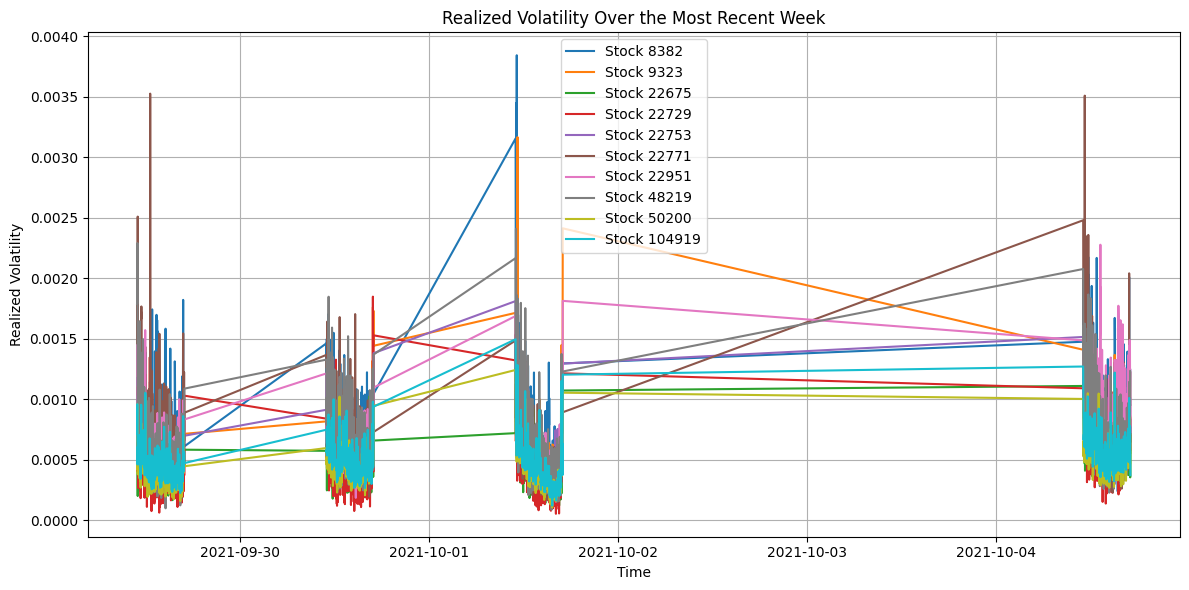

In [9]:
train_df['date'] = pd.to_datetime(train_df['date'])

latest_date = train_df['date'].max()

# Filter for the most recent 7 days
recent_df = train_df[train_df['date'] >= (latest_date - pd.Timedelta(days=6))].copy()

# Recreate the timestamp using date + time + bucket_start
recent_df['timestamp'] = pd.to_datetime(recent_df['date'].dt.strftime('%Y-%m-%d') + ' ' + recent_df['time']) + \
                         pd.to_timedelta(recent_df['bucket_start'], unit='s')

plt.figure(figsize=(12, 6))

# Plot realized volatility over time for each stock
for stock_id, group in recent_df.groupby('stock_id'):
    if group.empty or 'realized_volatility' not in group.columns:
        continue

    group = group.sort_values('timestamp')
    plt.plot(group['timestamp'], group['realized_volatility'], label=f'Stock {int(stock_id)}')

plt.xlabel("Time")
plt.ylabel("Realized Volatility")
plt.title("Realized Volatility Over the Most Recent Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

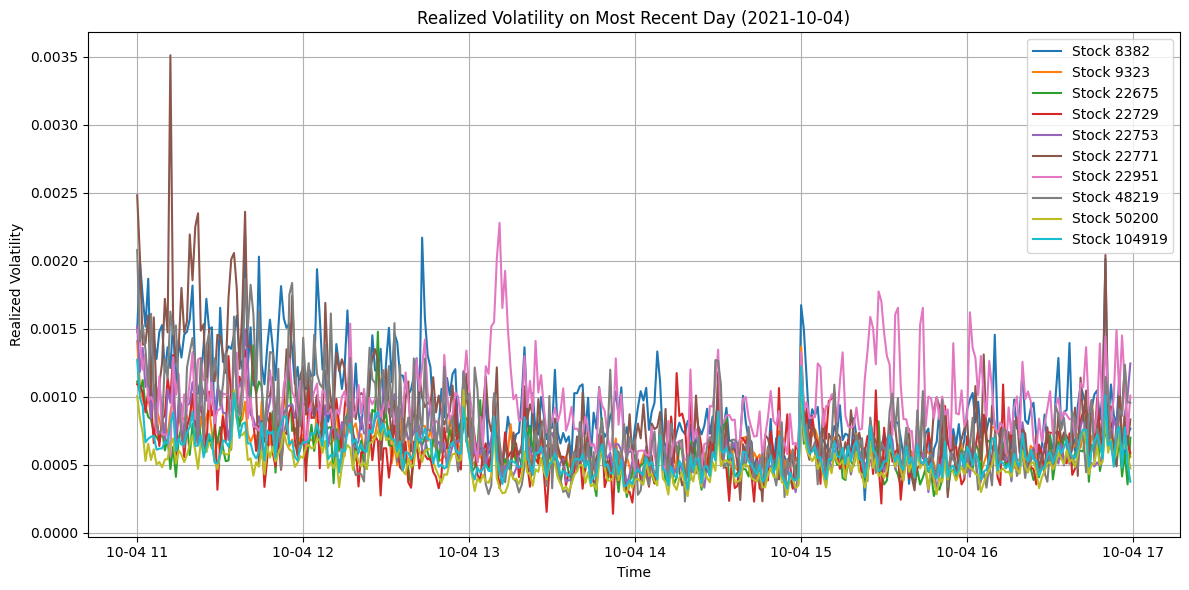

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])

# Get the most recent date
latest_date = train_df['date'].max()

# Filter for the most recent day
recent_df = train_df[train_df['date'] == latest_date].copy()

# Recreate timestamp using date + time + bucket_start
recent_df['timestamp'] = pd.to_datetime(recent_df['date'].dt.strftime('%Y-%m-%d') + ' ' + recent_df['time']) + \
                         pd.to_timedelta(recent_df['bucket_start'], unit='s')

plt.figure(figsize=(12, 6))

# Plot realized volatility over time for each stock
for stock_id, group in recent_df.groupby('stock_id'):
    if group.empty or 'realized_volatility' not in group.columns:
        continue

    group = group.sort_values('timestamp')
    plt.plot(group['timestamp'], group['realized_volatility'], label=f'Stock {int(stock_id)}')

plt.xlabel("Time")
plt.ylabel("Realized Volatility")
plt.title(f"Realized Volatility on Most Recent Day ({latest_date.date()})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import statsmodels.tsa.stattools as smt
from collections import defaultdict

# Parameters
lags_to_check = 5
grouped_stocks = defaultdict(list)
stock_data_by_cutoff = {}

# Ensure 'date' is datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Create timestamp from date + time + bucket_start (as seconds from start of hour)
train_df['timestamp'] = pd.to_datetime(train_df['date'].dt.strftime('%Y-%m-%d') + ' ' + train_df['time']) + \
                  pd.to_timedelta(train_df['bucket_start'], unit='s')

# Optionally compute log returns if not in the DataFrame
if 'log_return' not in train_df.columns:
    train_df = train_df.sort_values(['stock_id', 'timestamp'])
    train_df['log_return'] = train_df.groupby('stock_id')['realized_volatility'].transform(lambda x: np.log(x + 1e-8).diff())


# Drop NaNs introduced by diff
train_df = train_df.dropna(subset=['log_return'])

def detect_pacf_cutoff(pacf_vals, conf_int):
    for lag in range(1, len(pacf_vals)):
        lower, upper = conf_int[lag]
        if lower < 0 < upper:
            return lag - 1
    return len(pacf_vals) - 1 

# Process each stock individually
for stock_id, group in train_df.groupby('stock_id'):
    group = group.sort_values('timestamp')
    
    spread_mean = group.groupby('bucket_start')['log_return'].mean().sort_index()

    pacf_vals, confint = smt.pacf(spread_mean, nlags=lags_to_check, alpha=0.05, method='ywm')
    cutoff = detect_pacf_cutoff(pacf_vals, confint)

    grouped_stocks[cutoff].append(stock_id)

    if cutoff not in stock_data_by_cutoff:
        stock_data_by_cutoff[cutoff] = (stock_id, spread_mean)

# Print results
print("The stocks without cutoff at 0:")
for cutoff, stocks in grouped_stocks.items():
    if cutoff != 0:
        print(f"PACF cutoff lag {cutoff}: {stocks}")


The stocks without cutoff at 0:
PACF cutoff lag 1: [9323.0, 22675.0, 22729.0, 22753.0, 22771.0, 22951.0, 48219.0, 50200.0, 104919.0]


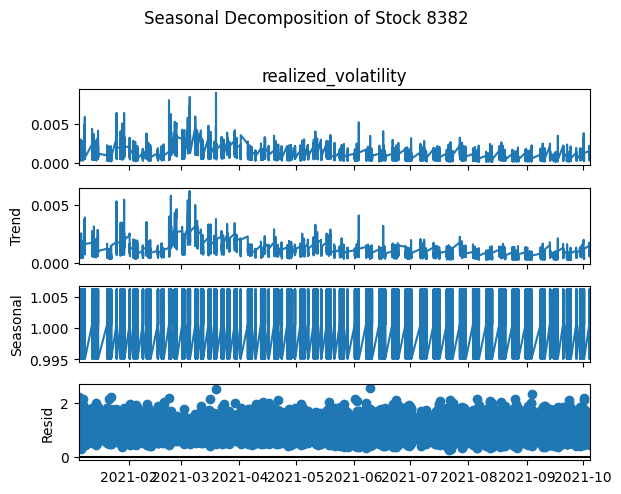

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure date and timestamp are correct
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['timestamp'] = pd.to_datetime(train_df['date'].dt.strftime('%Y-%m-%d') + ' ' + train_df['time']) + \
                  pd.to_timedelta(train_df['bucket_start'], unit='s')

# Choose the stock with the most data
top_stock_id = train_df['stock_id'].value_counts().idxmax()
stock_df = train_df[train_df['stock_id'] == top_stock_id].copy()

# Sort by time and set index
stock_df = stock_df.sort_values('timestamp').set_index('timestamp')

# Use log return or realized volatility
ts = stock_df['realized_volatility']

# Drop NA or zero values for multiplicative model
ts = ts.replace(0, np.nan).dropna()

# Ensure regular frequency (optional: resample if needed)
# ts = ts.resample('1min').mean().interpolate()

# Decompose
decomp = seasonal_decompose(ts, model='multiplicative', period=4)
decomp.plot()
plt.suptitle(f'Seasonal Decomposition of Stock {int(top_stock_id)}', y=1.02)
plt.tight_layout()
plt.show()


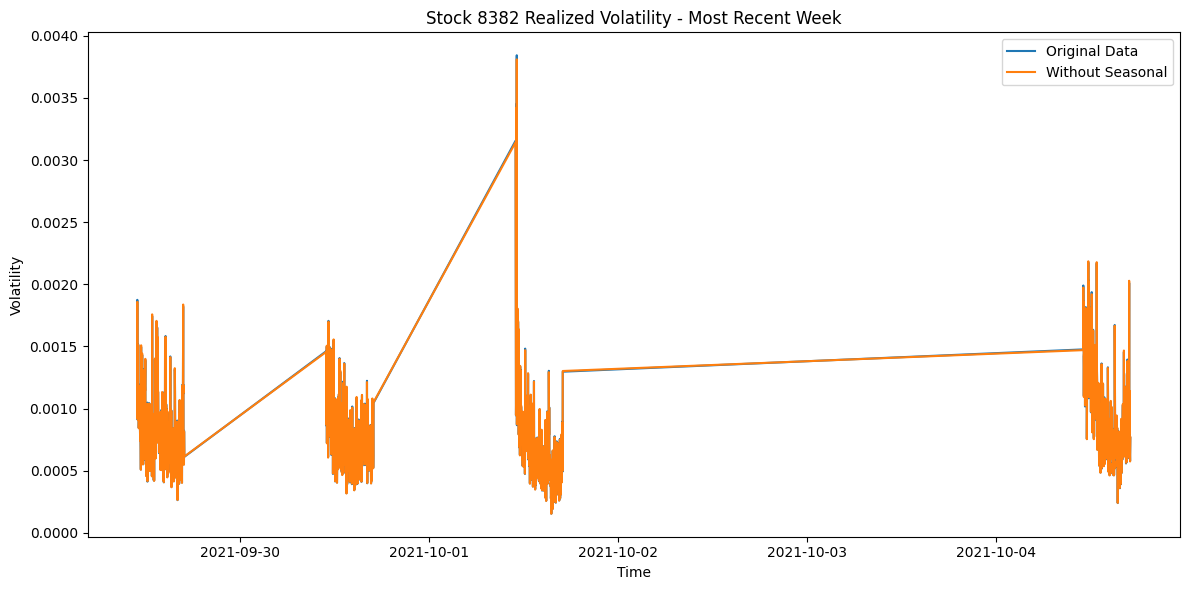

In [13]:
top_stock_id = train_df['stock_id'].value_counts().idxmax()
stock_df = train_df[train_df['stock_id'] == top_stock_id].copy()

# Sort and index by timestamp
stock_df = stock_df.sort_values('timestamp').set_index('timestamp')

most_recent_date = stock_df['date'].max()
one_week_df = stock_df[stock_df['date'] >= (most_recent_date - pd.Timedelta(days=6))]

# Use realized_volatility (cleaned)
ts_log = one_week_df['realized_volatility'].replace(0, np.nan).dropna()

# Optional: resample to regular frequency if needed (e.g., every 60s)
# ts_log = ts_log.resample('60s').mean().interpolate()

# Ensure enough data points for period
if len(ts_log) < 8:
    raise ValueError("Not enough data points in the most recent week to decompose with period=4.")

# Decompose
result = seasonal_decompose(ts_log, model='multiplicative', extrapolate_trend='freq', period=4)

# Remove seasonal component
without_seasonal = ts_log / result.seasonal

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts_log, label='Original Data')
plt.plot(without_seasonal, label='Without Seasonal')
plt.title(f"Stock {int(top_stock_id)} Realized Volatility - Most Recent Week")
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()


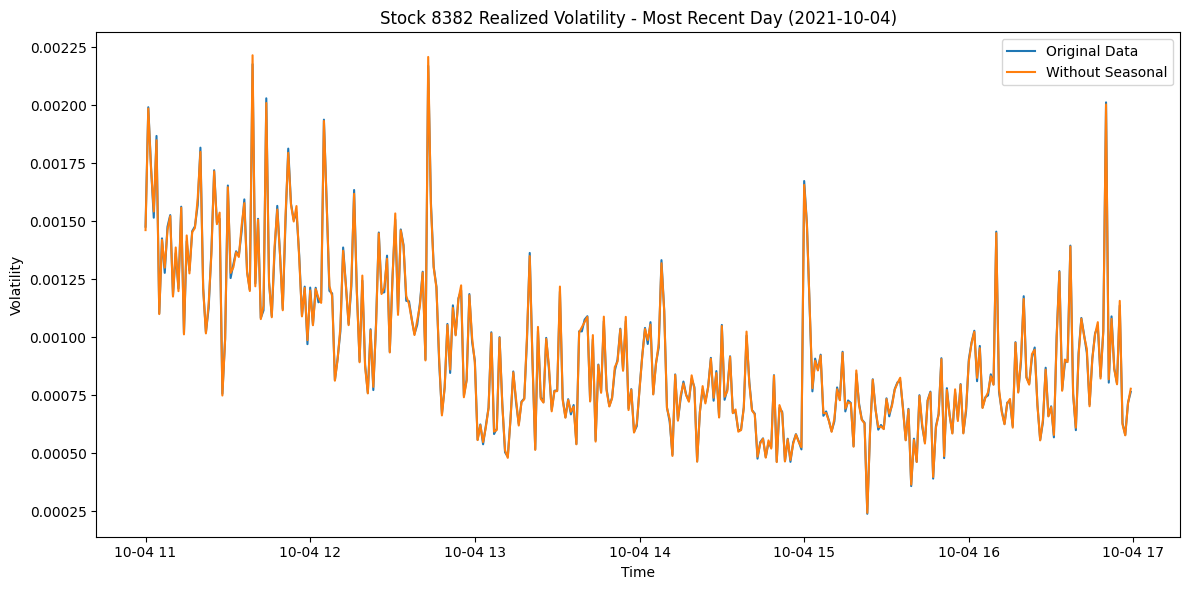

In [14]:
# Pick the stock with the most data
top_stock_id = train_df['stock_id'].value_counts().idxmax()
stock_df = train_df[train_df['stock_id'] == top_stock_id].copy()

# Sort and index
stock_df = stock_df.sort_values('timestamp').set_index('timestamp')

# Filter for most recent day
most_recent_day = stock_df['date'].max()
one_day_df = stock_df[stock_df['date'] == most_recent_day]

# Use realized volatility (or log_return)
ts_log = one_day_df['realized_volatility'].replace(0, np.nan).dropna()

# Optional: resample if spacing is irregular
# ts_log = ts_log.resample('10s').mean().interpolate()

# Ensure enough data for decomposition
if len(ts_log) < 8:
    raise ValueError("Not enough data points in the most recent day to decompose with period=4.")

# Decompose
result = seasonal_decompose(ts_log, model='multiplicative', extrapolate_trend='freq', period=4)

# Remove seasonal component
without_seasonal = ts_log / result.seasonal

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts_log, label='Original Data')
plt.plot(without_seasonal, label='Without Seasonal')
plt.title(f"Stock {int(top_stock_id)} Realized Volatility - Most Recent Day ({most_recent_day.date()})")
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()


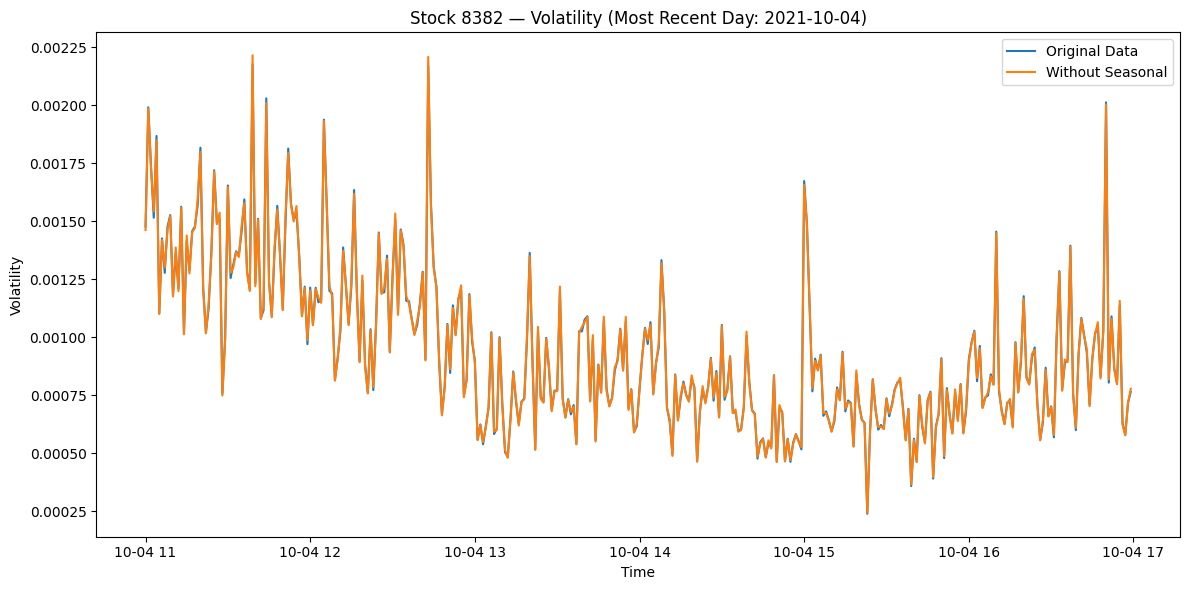

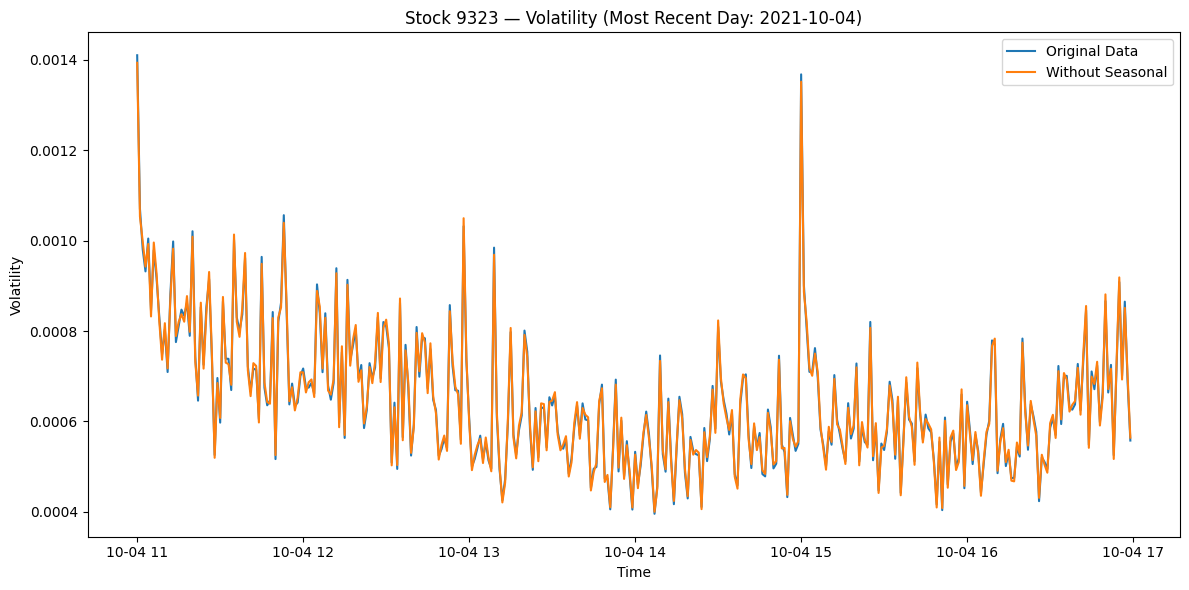

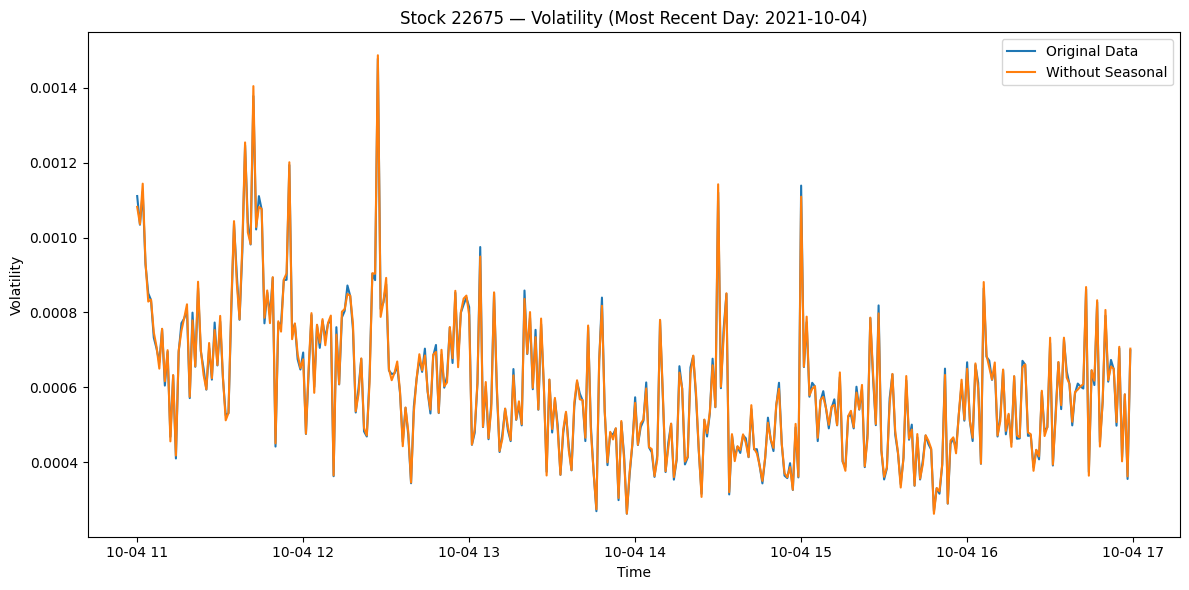

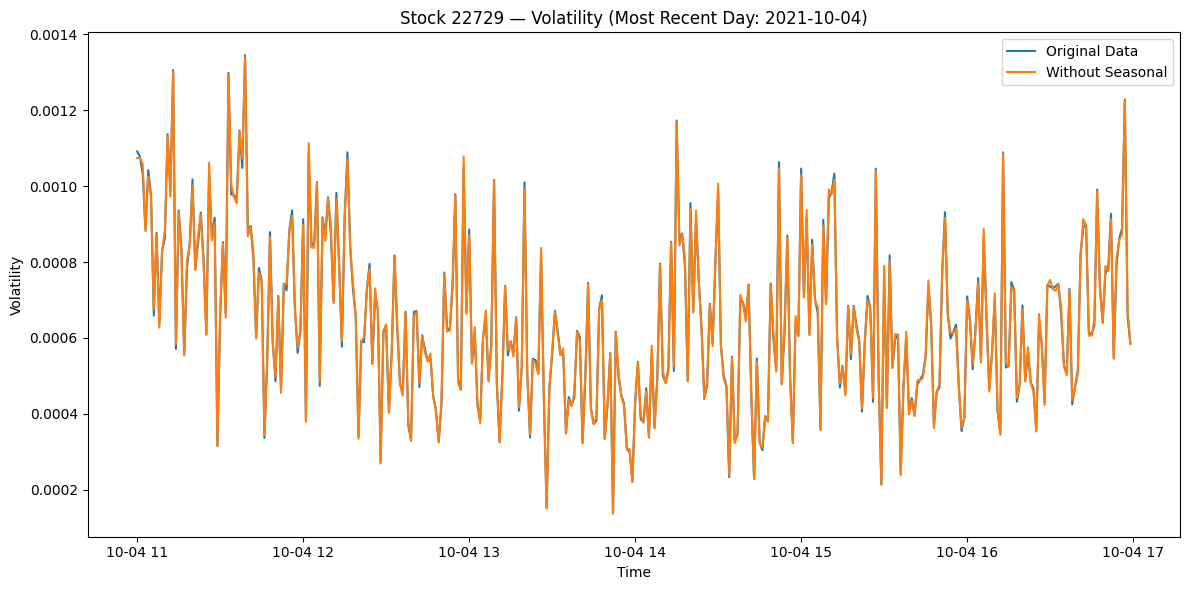

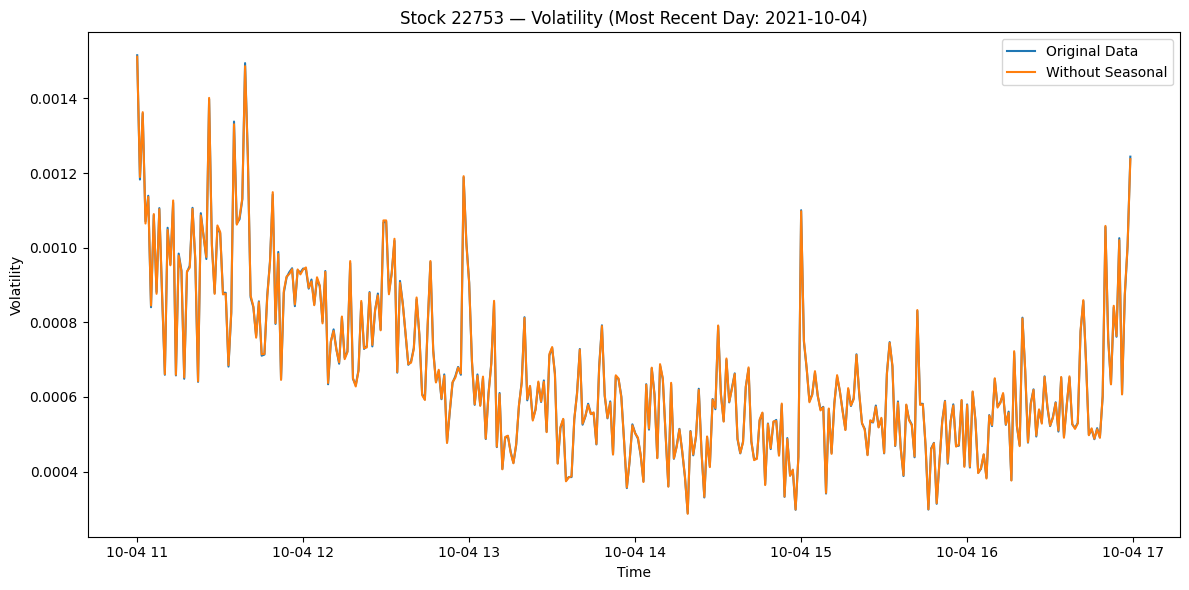

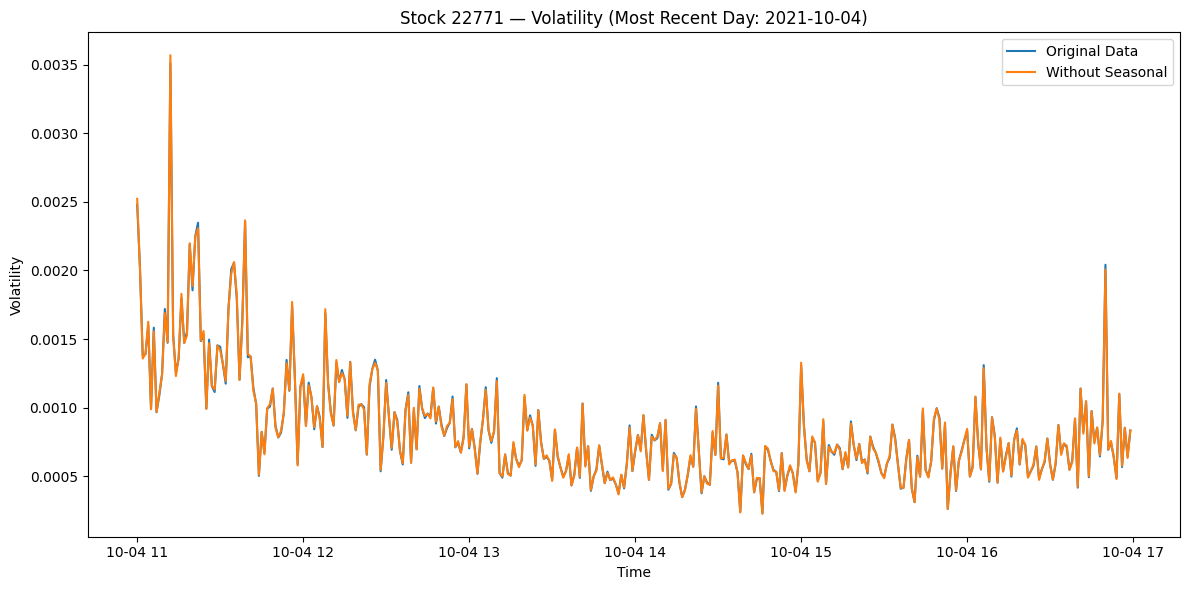

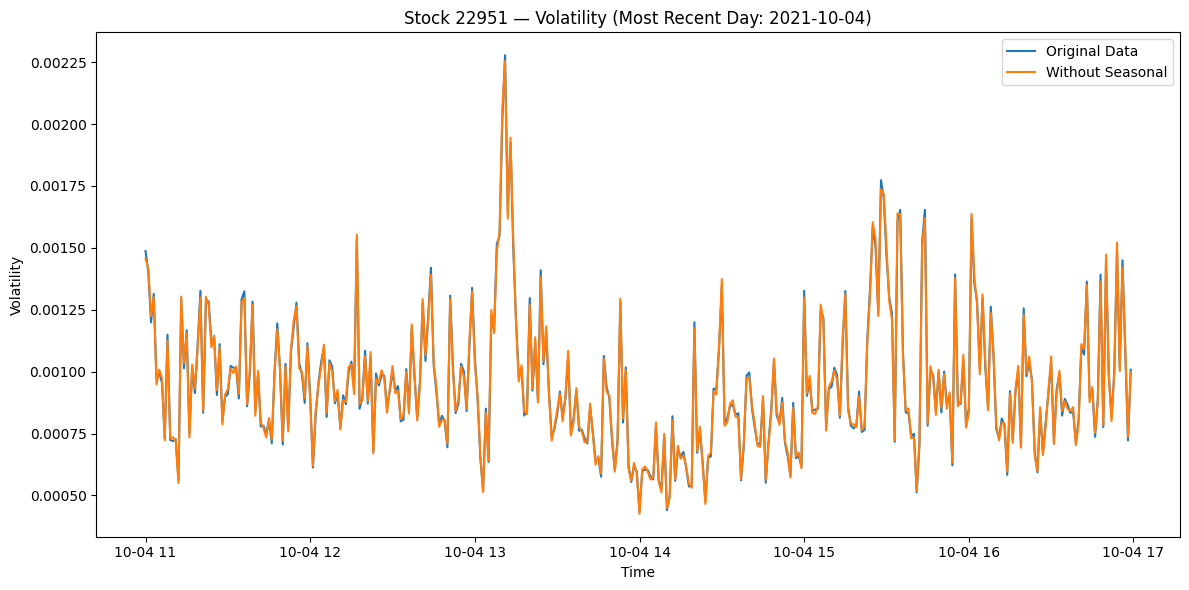

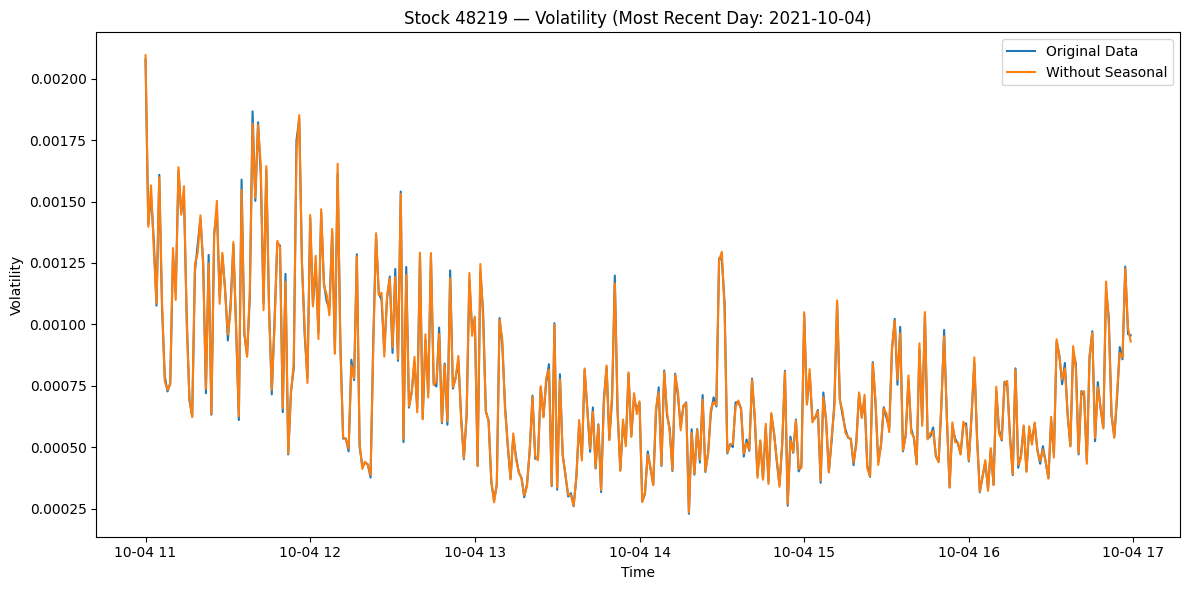

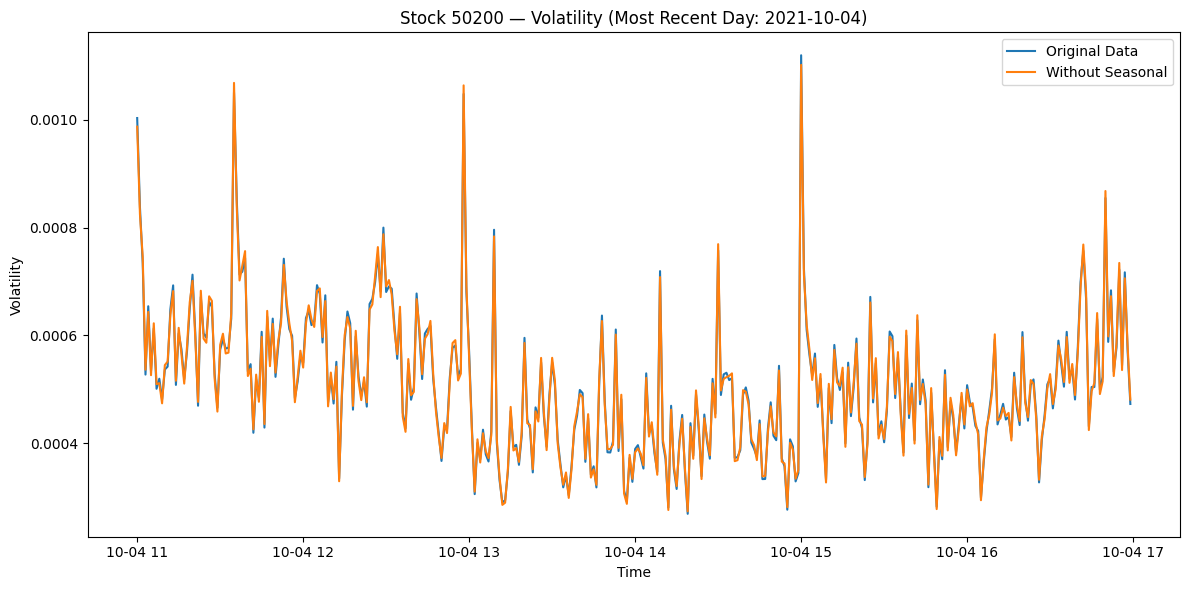

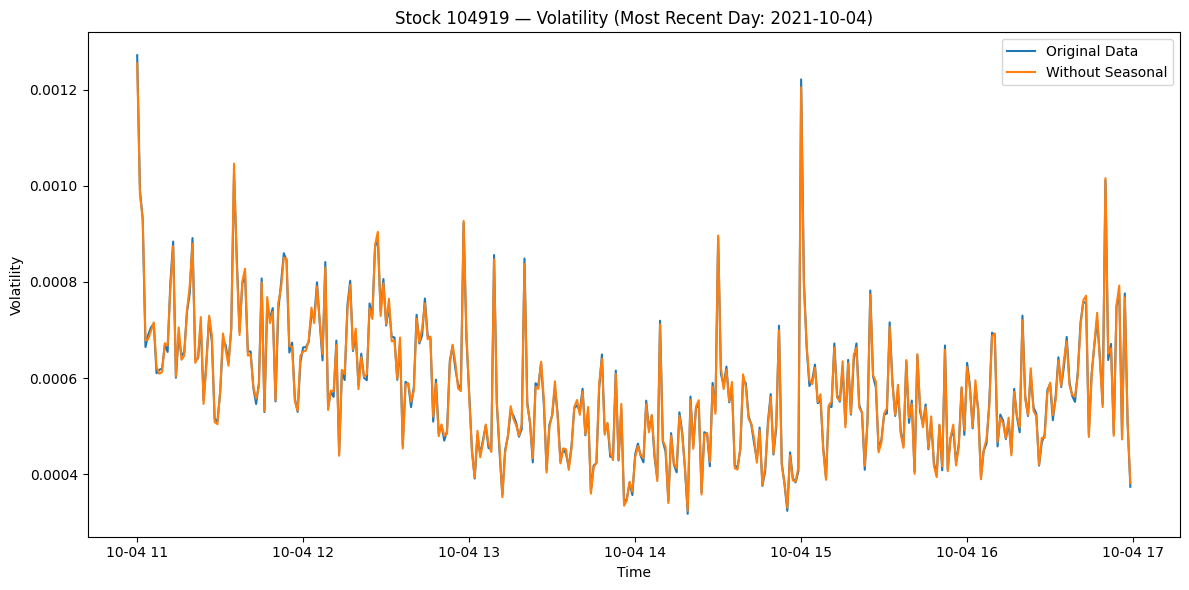

In [15]:
most_recent_day = train_df['date'].max()

# Filter the full DataFrame to just that day
df_day = train_df[train_df['date'] == most_recent_day].copy()

# Loop over each unique stock_id
for stock_id in df_day['stock_id'].unique():
    stock_df = df_day[df_day['stock_id'] == stock_id].copy()
    stock_df = stock_df.sort_values('timestamp').set_index('timestamp')

    ts_log = stock_df['realized_volatility'].replace(0, np.nan).dropna()

    # Skip stocks with insufficient data
    if len(ts_log) < 8:
        print(f"Skipping stock {int(stock_id)} — not enough data points.")
        continue

    try:
        result = seasonal_decompose(ts_log, model='multiplicative', extrapolate_trend='freq', period=4)
        without_seasonal = ts_log / result.seasonal

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(ts_log, label='Original Data')
        plt.plot(without_seasonal, label='Without Seasonal')
        plt.title(f'Stock {int(stock_id)} — Volatility (Most Recent Day: {most_recent_day.date()})')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Decomposition failed for stock {int(stock_id)}: {e}")


Plotting ACF/PACF for stock 8382


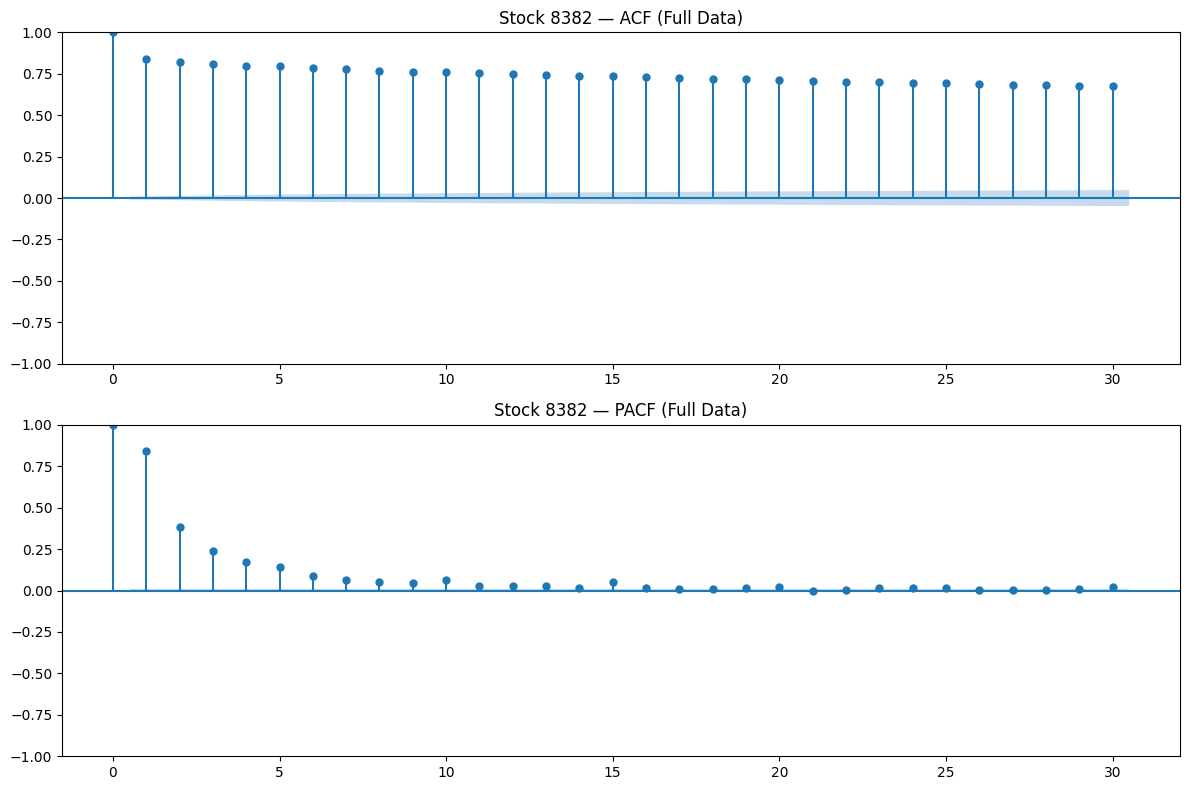

Plotting ACF/PACF for stock 9323


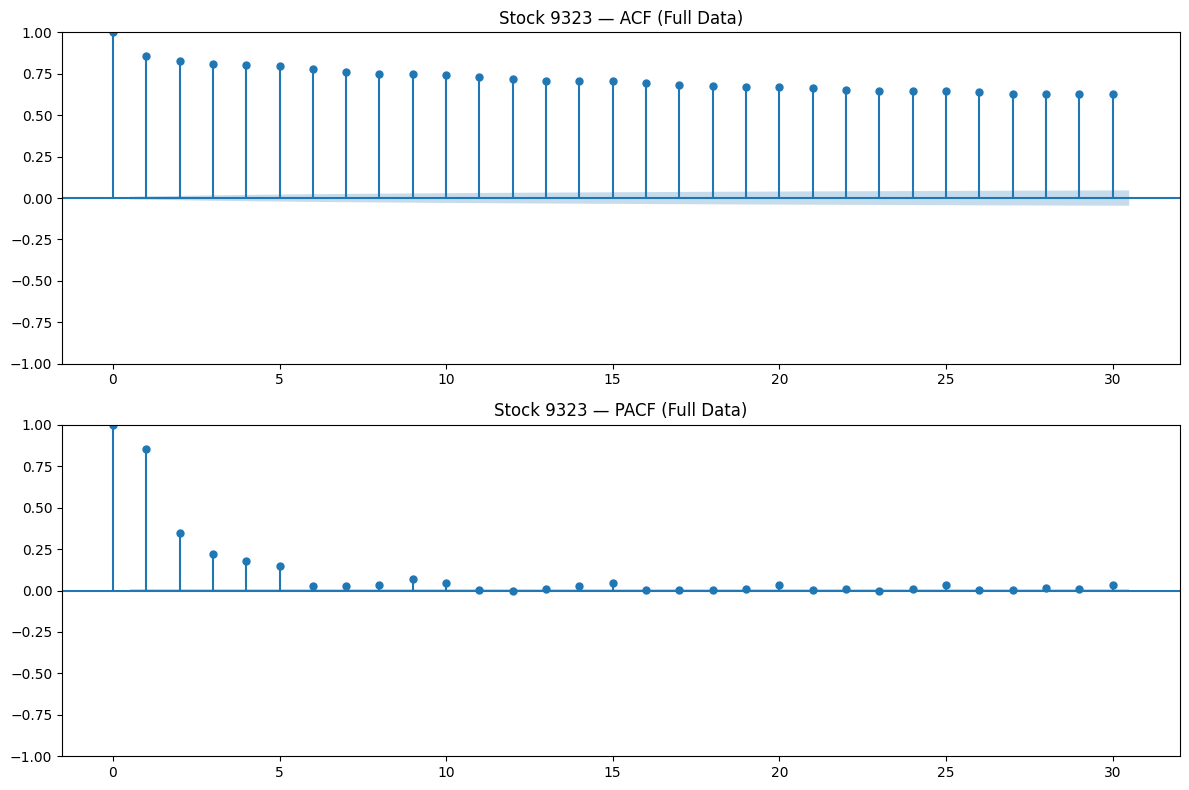

Plotting ACF/PACF for stock 22675


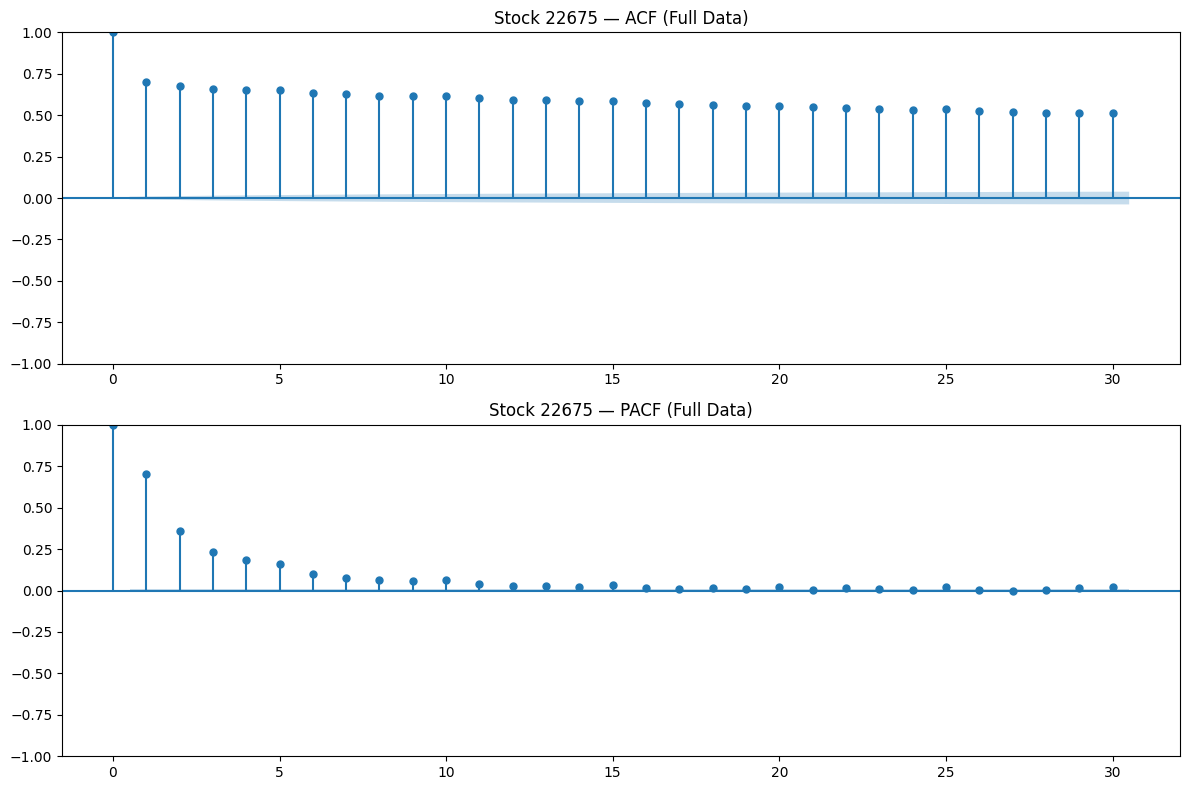

Plotting ACF/PACF for stock 22729


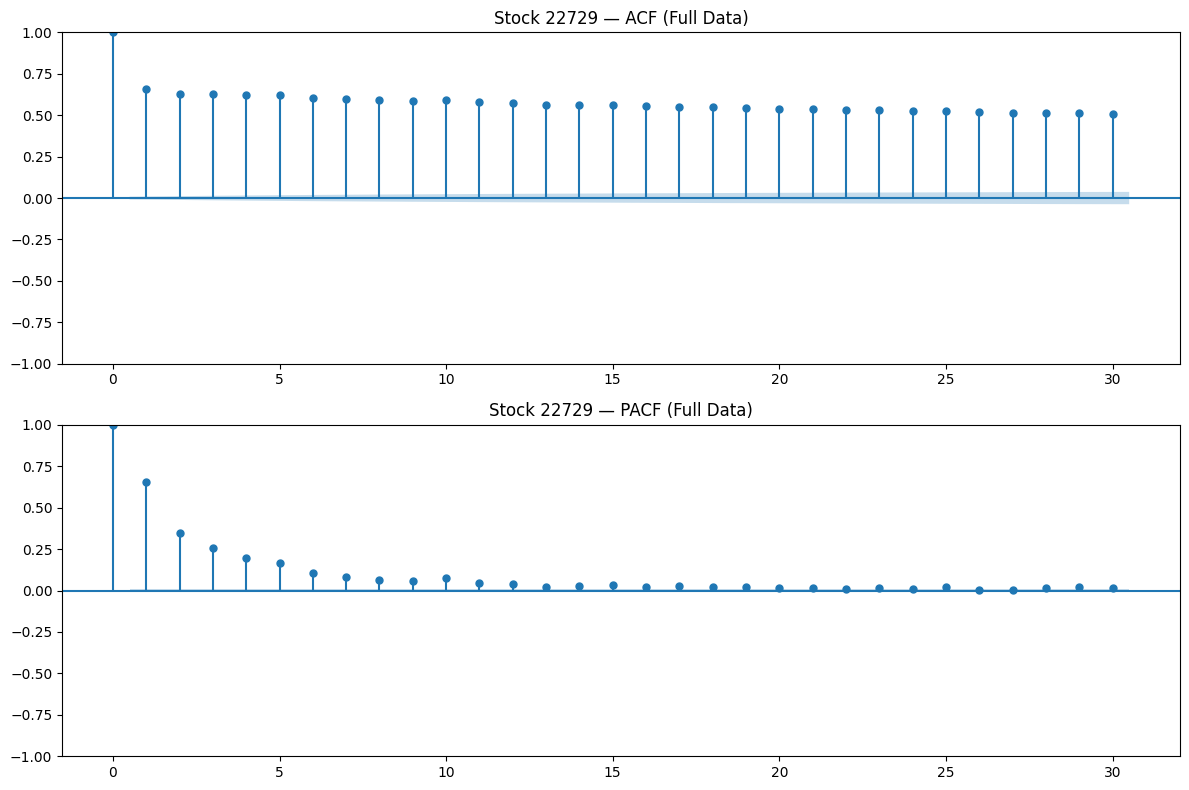

Plotting ACF/PACF for stock 22753


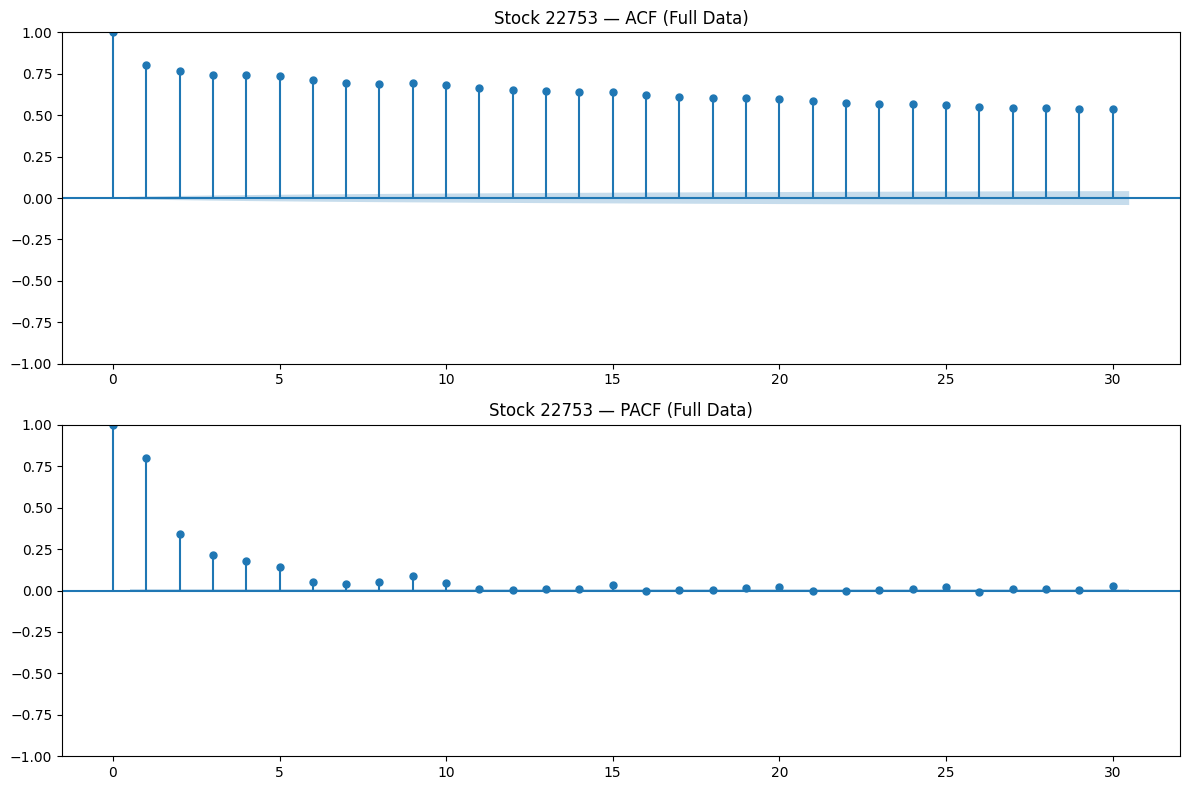

Plotting ACF/PACF for stock 22771


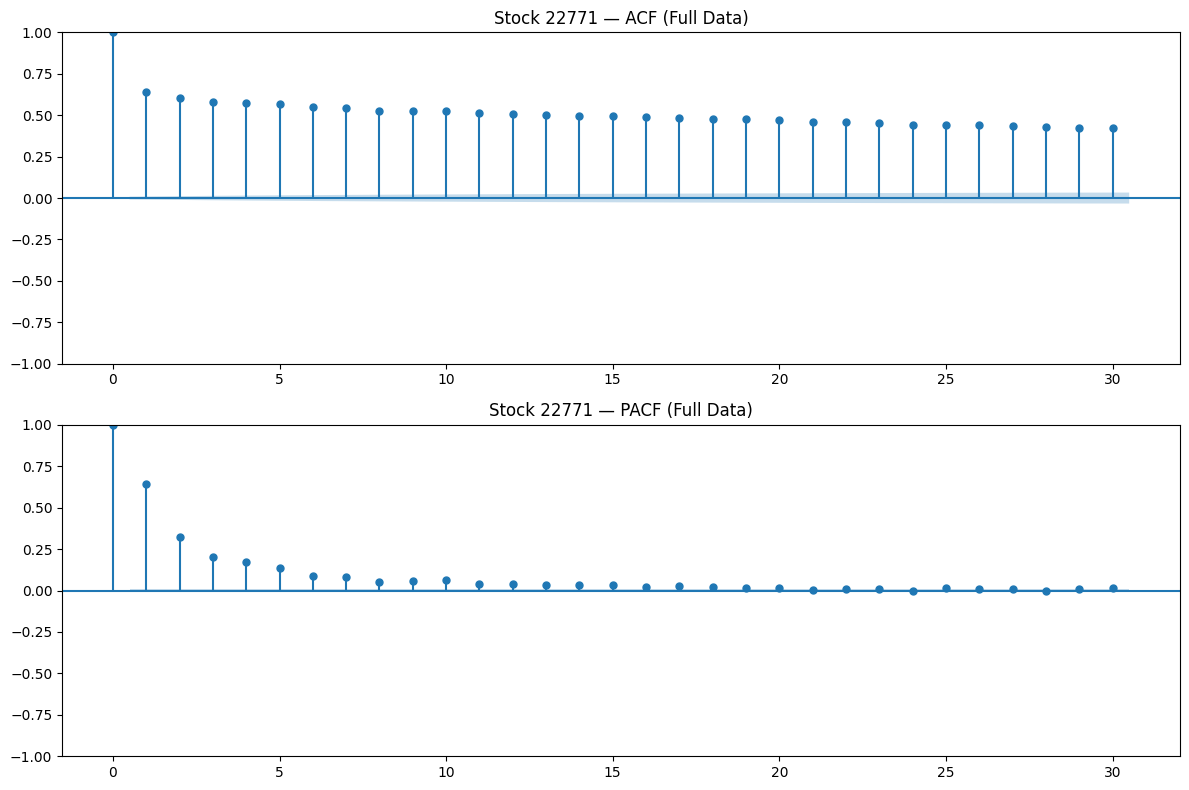

Plotting ACF/PACF for stock 22951


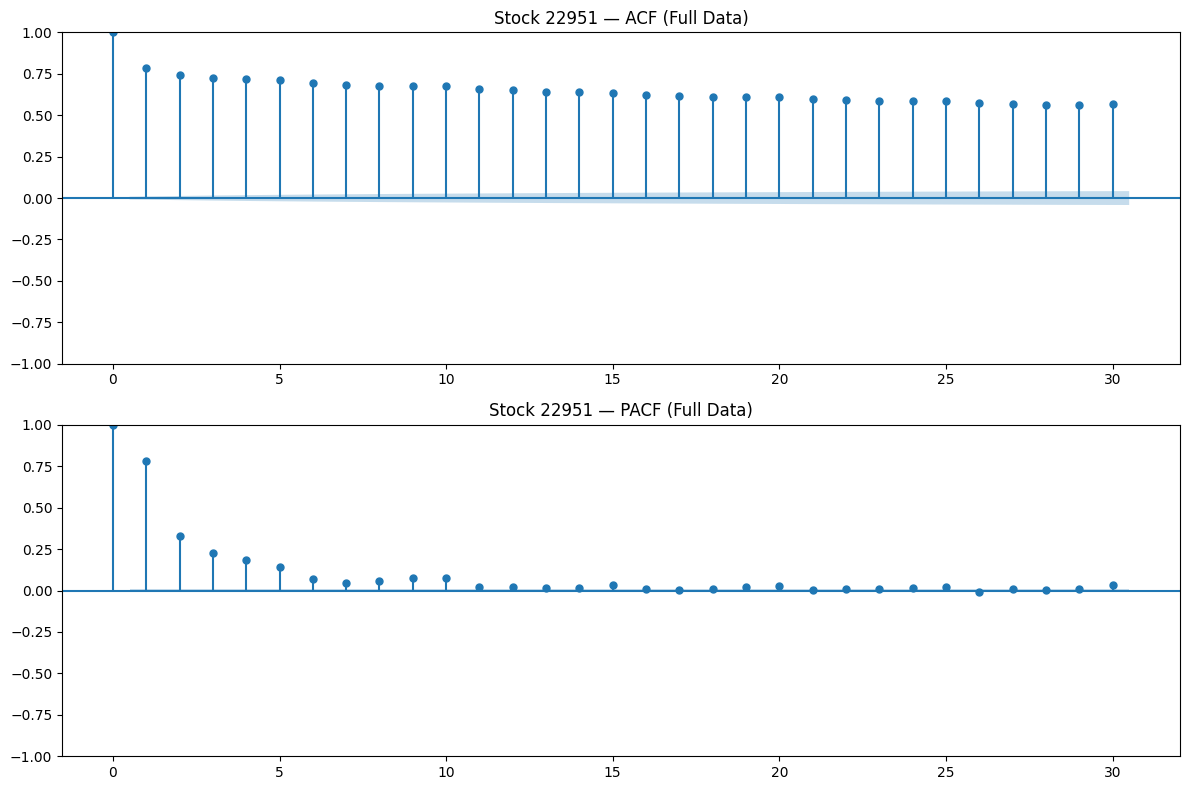

Plotting ACF/PACF for stock 48219


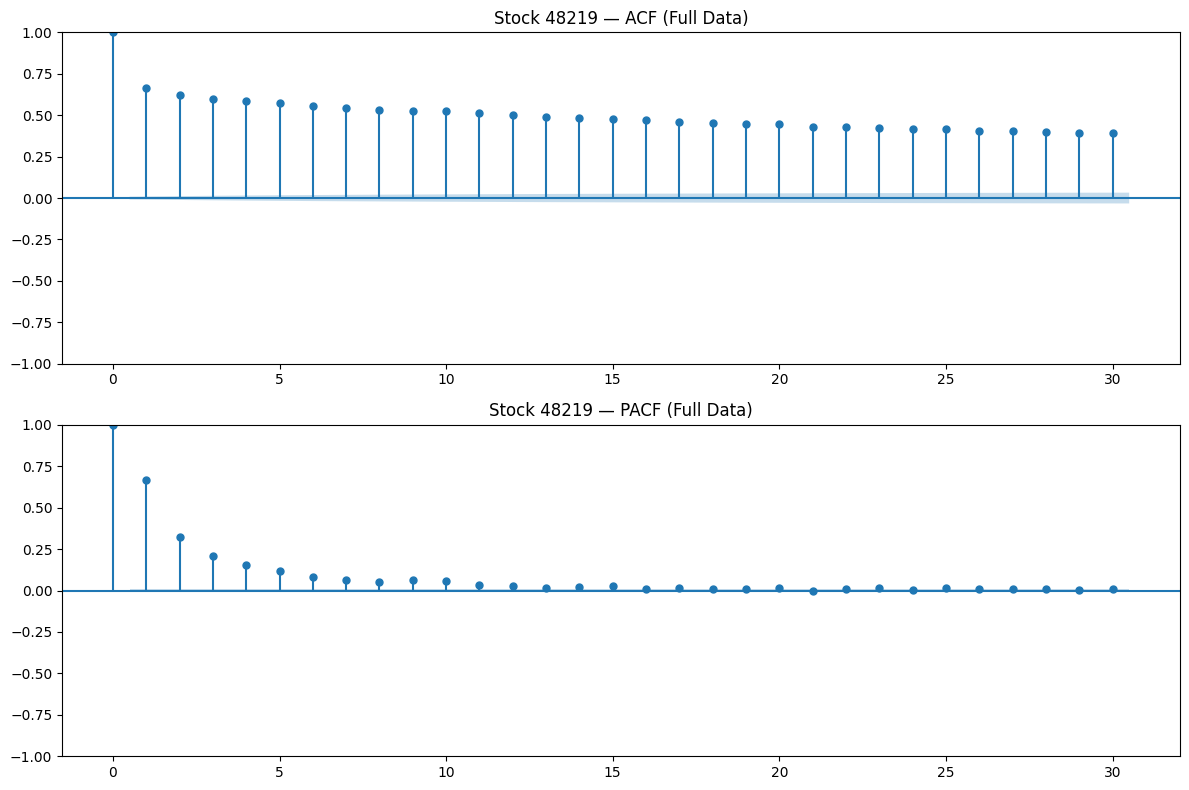

Plotting ACF/PACF for stock 50200


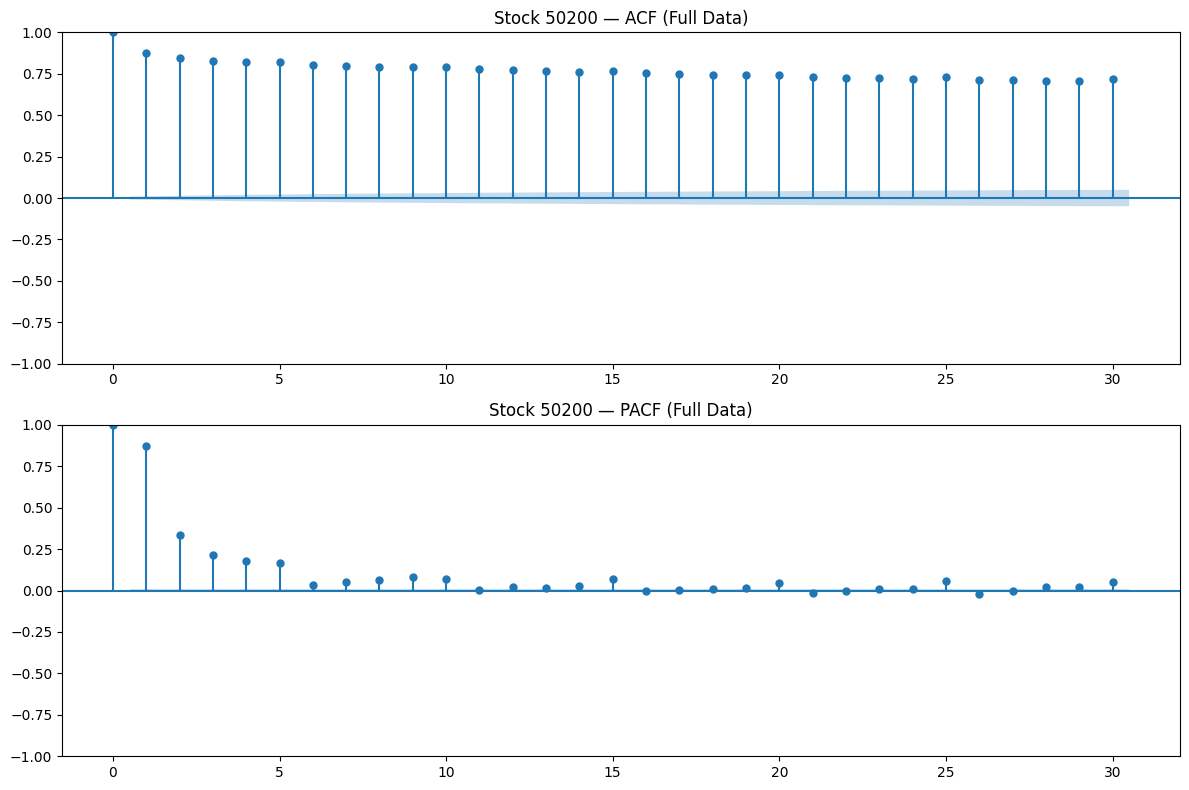

Plotting ACF/PACF for stock 104919


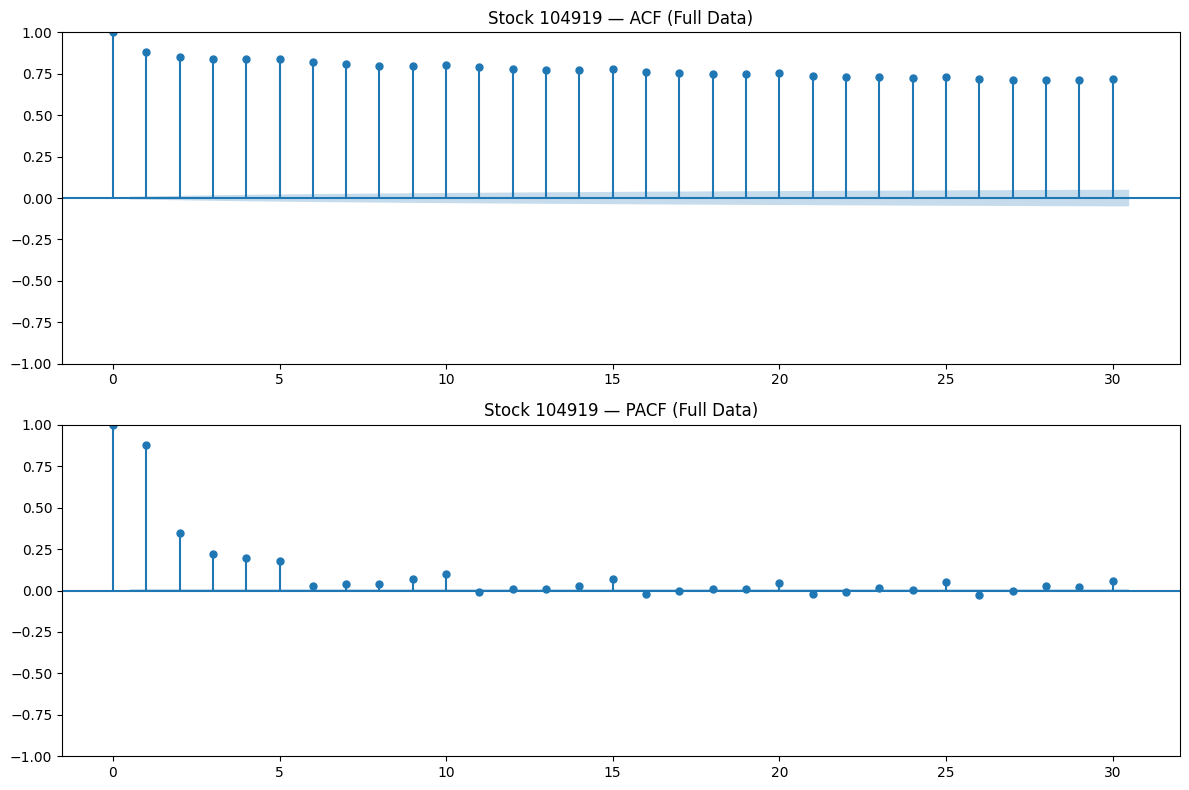

In [16]:
import statsmodels.api as smt

# Loop through each stock using all available data
for stock_id in train_df['stock_id'].unique():
    stock_df = train_df[train_df['stock_id'] == stock_id].copy()
    stock_df = stock_df.sort_values('timestamp').set_index('timestamp')

    # Use realized volatility or switch to 'log_return' if needed
    ts_log = stock_df['realized_volatility'].replace(0, np.nan).dropna()

    if len(ts_log) < 30:
        print(f"Skipping stock {int(stock_id)} — not enough data points for ACF/PACF.")
        continue

    print(f"Plotting ACF/PACF for stock {int(stock_id)}")

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    smt.graphics.tsa.plot_acf(ts_log, lags=30, alpha=0.05, ax=axes[0])
    smt.graphics.tsa.plot_pacf(ts_log, lags=30, alpha=0.05, ax=axes[1])

    axes[0].set_title(f'Stock {int(stock_id)} — ACF (Full Data)')
    axes[1].set_title(f'Stock {int(stock_id)} — PACF (Full Data)')
    plt.tight_layout()
    plt.show()


## Model building

In [17]:
import pandas as pd

# Assume df_train and df_test are your training and test DataFrames

# Sort and group
weekly_train = train_df.groupby(['stock_id', 'week', 'cluster']).agg({
    'log_ret_mean': 'mean',
    'log_ret_std': 'mean',
    'log_ret_sum': 'sum',
    'abs_volatility': 'mean',
    'realized_volatility': 'last',  # this is the target
    'rv_rolling': 'mean',
    'mom_rolling': 'mean',
    # Add any other predictors you want
}).reset_index()


In [18]:
import numpy as np
import warnings
from arch import arch_model

def safe_fit_garch(returns, scale_factor=1e8):
    try:
        # Defensive checks
        if len(returns) < 20 or np.std(returns) == 0 or np.isnan(returns).any():
            return np.nan

        # Scale and fit
        scaled = returns * scale_factor
        model = arch_model(scaled, vol='Garch', p=1, q=1, rescale=False)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = model.fit(disp='off')
            var_forecast = res.forecast(horizon=1).variance.values[-1] / (scale_factor ** 2)

        # Filter bad outputs
        if np.isnan(var_forecast) or np.isinf(var_forecast):
            return np.nan
        return var_forecast

    except Exception:
        return np.nan

garch_results = []

for (cluster, week), group in weekly_train.groupby(['cluster', 'week']):
    forecast_var = safe_fit_garch(group['log_ret_mean'].values)
    garch_results.append({'cluster': cluster, 'week': week, 'garch_forecast': forecast_var})

garch_df = pd.DataFrame(garch_results)
weekly_train = pd.merge(weekly_train, garch_df, on=['cluster', 'week'], how='left')


In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Features: include GARCH output and other rolling features
features = ['garch_forecast', 'log_ret_std', 'abs_volatility', 'rv_rolling', 'mom_rolling']
X = weekly_train[features].values
y = weekly_train['realized_volatility'].values

# Scale
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Reshape for LSTM [samples, time steps, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_lstm, y, epochs=50, verbose=0)   # Aggregate test data


c:\Users\karol\anaconda3\envs\clean_env\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\karol\anaconda3\envs\clean_env\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\karol\anaconda3\envs\clean_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Define the GARCH fitting function (as you have already defined)
def safe_fit_garch(returns, scale_factor=1e8):
    try:
        if len(returns) < 20 or np.std(returns) == 0 or np.isnan(returns).any():
            return np.nan

        scaled = returns * scale_factor
        model = arch_model(scaled, vol='Garch', p=1, q=1, rescale=False)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = model.fit(disp='off')
            var_forecast = res.forecast(horizon=1).variance.values[-1] / (scale_factor ** 2)

        if np.isnan(var_forecast) or np.isinf(var_forecast):
            return np.nan
        return var_forecast

    except Exception:
        return np.nan

# Calculate GARCH forecast for the test data
garch_results_test = []

# Loop over the test dataset by stock_id and week
for (stock_id, week), group in test_df.groupby(['stock_id', 'week']):
    forecast_var = safe_fit_garch(group['log_ret_mean'].values)
    garch_results_test.append({'stock_id': stock_id, 'week': week, 'garch_forecast': forecast_var})

# Create a DataFrame for the GARCH forecasts in the test set
garch_df_test = pd.DataFrame(garch_results_test)

# Merge the GARCH forecast with the test dataset
testing_data = pd.merge(test_df, garch_df_test, on=['stock_id', 'week'], how='left')


In [59]:
# Features for LSTM input (including GARCH forecast)
test_features = ['garch_forecast', 'log_ret_std', 'abs_volatility', 'rv_rolling', 'mom_rolling']

# Extract features from the testing data
X_test = testing_data[test_features].values

# Scale the features using the same scaler fitted on training data
X_test_scaled = scaler_X.transform(X_test)

# Reshape for LSTM input (samples, time steps, features)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [60]:
# Predicting realized volatility on the test set
y_pred = model.predict(X_test_lstm)
y_pred

8550/8550 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [ ]:
# Evaluate the model using Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(testing_data['realized_volatility'].values, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

# Evaluate the model using Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(testing_data['realized_volatility'].values, y_pred)
print(f"Mean Absolute Error on Test Data: {mae}")

# Visualizing predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(testing_data['date'], testing_data['realized_volatility'], label='Actual Realized Volatility')
plt.plot(testing_data['date'], y_pred, label='Predicted Realized Volatility', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.title('Predicted vs Actual Realized Volatility')
plt.legend()
plt.show()


# MODEL BUIDING PT 2

In [61]:
from arch import arch_model

# Fit a GARCH model
def fit_garch(data):
    model = arch_model(data, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")
    return garch_fit

garch_model = fit_garch(test_df['log_ret_mean'])
garch_volatility = garch_model.conditional_volatility  # Predicted volatility


c:\Users\karol\anaconda3\envs\clean_env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.217e-10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\karol\anaconda3\envs\clean_env\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import numpy as np

# Example function to prepare data for LSTM
def prepare_lstm_data(features, target, timesteps=1):
    X, y = [], []
    for i in range(len(features) - timesteps):
        X.append(features[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

label_encoder = LabelEncoder()
features['garch_forecast'] = label_encoder.fit_transform(features['garch_forecast'])

# Prepare data for LSTM
X, y = prepare_lstm_data(features, train_df['realized_volatility'])
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Reshape for LSTM input

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for volatility prediction

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)


TypeError: list indices must be integers or slices, not str

In [ ]:
# Apply the trained GARCH model to test data
test_garch_volatility = garch_model.conditional_volatility

# Preprocess and prepare LSTM data from test data
scaled_test_features = scaler.transform(test_features)
X_test, y_test = prepare_lstm_data(scaled_test_features, test_data['realized_volatility'])

# Predict using the LSTM model
predicted_volatility = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error
import math

# RMSE
rmse = math.sqrt(mean_squared_error(y_test, predicted_volatility))
print(f"RMSE: {rmse}")


In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual Realized Volatility')
plt.plot(test_data['date'], predicted_volatility, label='Predicted Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.title('Predicted vs Actual Realized Volatility')
plt.legend()
plt.show()
